# Twitter Sentiment Analysis
This notebook is a report on the Data Mining class assignment.

*by* ***Konstantina Stoikou (1115201500151)***

Let's load the python libraries and have a look at the dataset.

In [0]:
%matplotlib inline

import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import gensim
import statistics
import warnings
from IPython.display import Image
from bs4 import BeautifulSoup
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from collections import OrderedDict
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from matplotlib.ticker import MaxNLocator
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier

# suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None 
# supppress DeprecationWarning
warnings.filterwarnings("ignore", category=DeprecationWarning) 

First we have to read the train data and store them into a Pandas dataframe. Also you have to set the paths of the files/folders in your local file system that you want to save/load data during the program execution.

In [0]:
# SET YOUR LOCAL PATHS to be used later in the program

# paths to train/test/evaluation data files
train_path = '/media/admin1/data/COMMON STORAGE/Sxoli/Data Mining/Project/twitter_data/train2017.tsv'
test_path = '/media/admin1/data/COMMON STORAGE/Sxoli/Data Mining/Project/twitter_data/test2017.tsv'
eval_path = '/media/admin1/data/COMMON STORAGE/Sxoli/Data Mining/Project/twitter_data/SemEval2017_task4_subtaskA_test_english_gold.txt'
# the path to the folder to store pickle files
pickles_path = '/media/admin1/data/COMMON STORAGE/Sxoli/Data Mining/Project/scr/jupyter_pickles/'
# the path to the pretrained word2vec model
pretrainmodel_path = '/media/admin1/data/COMMON STORAGE/Sxoli/Data Mining/GoogleNews-vectors-negative300.bin'
# path to the folder with lexicas
lexica_path = '/media/admin1/data/COMMON STORAGE/Sxoli/Data Mining/Project/lexica/'
# path to folder to store images
images_path = '/media/admin1/data/COMMON STORAGE/Sxoli/Data Mining/Project/scr/stats_images/'

# read train dataset
train_df = pd.read_csv(train_path, engine='python', sep='\t+', names=['Id', 'Number2', 'Sentiment', 'Tweet'])

train_df.head(10)

,Id,Number2,Sentiment,Tweet
0,264183816548130816,15140428,positive,Gas by my house hit $3.39!!!! I'm going to Cha...
1,263405084770172928,591166521,negative,"Theo Walcott is still shit, watch Rafa and Joh..."
2,262163168678248449,35266263,negative,"its not that I'm a GSP fan, i just hate Nick D..."
3,264249301910310912,18516728,negative,Iranian general says Israel's Iron Dome can't ...
4,262682041215234048,254373818,neutral,"Tehran, Mon Amour: Obama Tried to Establish Ti..."
5,264229576773861376,518129399,neutral,I sat through this whole movie just for Harry ...
6,264105751826538497,147088367,positive,with J Davlar 11th. Main rivals are team Polan...
7,264094586689953794,332474633,negative,"Talking about ACT's && SAT's, deciding where I..."
8,212392538055778304,274996324,neutral,"Why is \""""Happy Valentines Day\"""" trending? It..."
9,254941790757601280,557103111,negative,"They may have a SuperBowl in Dallas, but Dalla..."


## Preprocessing train data
If you have already run this notebook, you can skip this section and load a pickle with the already cleaned dataset. 

### Data cleaning

We will now define our cleaning function that will be applied to the tweets.






In [0]:
def clean(text):
    """ Clean the text and return the cleaned text. """

    # make all letters lowercase
    text = text.lower()
    
    # remove @mentions
    text = re.sub('@[A-Za-z0-9]+', '', text)
    
    # remove URLs
    text = re.sub('https?://[A-Za-z0-9./]+', '', text)
    
    # remove HTML encoding
    text = BeautifulSoup(text, 'lxml').get_text()
    
    # remove punctuation, numbers, hashtag symbols
    text = re.sub("[^a-zA-Z]", ' ', text)
    
    # remove extra whitespaces between words
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

Apply clean function to the tweets.

In [0]:
train_df['Tweet'] = train_df['Tweet'].apply(lambda x: clean(x))

train_df.head(10)

,Id,Number2,Sentiment,Tweet
0,264183816548130816,15140428,positive,gas by my house hit i m going to chapel hill o...
1,263405084770172928,591166521,negative,theo walcott is still shit watch rafa and john...
2,262163168678248449,35266263,negative,its not that i m a gsp fan i just hate nick di...
3,264249301910310912,18516728,negative,iranian general says israel s iron dome can t ...
4,262682041215234048,254373818,neutral,tehran mon amour obama tried to establish ties...
5,264229576773861376,518129399,neutral,i sat through this whole movie just for harry ...
6,264105751826538497,147088367,positive,with j davlar th main rivals are team poland h...
7,264094586689953794,332474633,negative,talking about act s sat s deciding where i wan...
8,212392538055778304,274996324,neutral,why is happy valentines day trending it s on t...
9,254941790757601280,557103111,negative,they may have a superbowl in dallas but dallas...


### Tokenization and stopwords removal

We will now tokenize the tweets and remove stopwords from them.

In [0]:
def tokenize(text):
    """ Tokenize text into words and remove stopwords, return filtered tokens list. """

    tokens = word_tokenize(text)
    # remove stopwords from tokens
    filtered = [w for w in tokens if not w in stopwords.words('english')]
    return filtered
  
    
train_df['Tweet'] = train_df['Tweet'].apply(lambda x: tokenize(x))

train_df.head(10)

,Id,Number2,Sentiment,Tweet
0,264183816548130816,15140428,positive,"[gas, house, hit, going, chapel, hill, sat]"
1,263405084770172928,591166521,negative,"[theo, walcott, still, shit, watch, rafa, john..."
2,262163168678248449,35266263,negative,"[gsp, fan, hate, nick, diaz, wait, february]"
3,264249301910310912,18516728,negative,"[iranian, general, says, israel, iron, dome, d..."
4,262682041215234048,254373818,neutral,"[tehran, mon, amour, obama, tried, establish, ..."
5,264229576773861376,518129399,neutral,"[sat, whole, movie, harry, ron, christmas, ohl..."
6,264105751826538497,147088367,positive,"[j, davlar, th, main, rivals, team, poland, ho..."
7,264094586689953794,332474633,negative,"[talking, act, sat, deciding, want, go, colleg..."
8,212392538055778304,274996324,neutral,"[happy, valentines, day, trending, th, februar..."
9,254941790757601280,557103111,negative,"[may, superbowl, dallas, dallas, winning, supe..."


### Lemmatization

The words of the tweets will be now lemmatized. For better lemmatization we provide the correct ‘part-of-speech’ tag (POS tag) as the second argument to lemmatize(). We choose lemmatization over stemming because it is more efficient (as we will see later in results).




In [0]:
def get_wordnet_pos(word):
    """ Map POS tag to first character lemmatize() accepts. """
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize(tokens):
    """ Lemmatize all words in given list of tokens. """

    lemmatizer = WordNetLemmatizer()
    lems = [lemmatizer.lemmatize(token, get_wordnet_pos(token))
            for token in tokens]

    return lems


train_df['Tweet'] = train_df['Tweet'].apply(lambda x: lemmatize(x))

train_df.head(10)

,Id,Number2,Sentiment,Tweet
0,264183816548130816,15140428,positive,"[gas, house, hit, go, chapel, hill, sat]"
1,263405084770172928,591166521,negative,"[theo, walcott, still, shit, watch, rafa, john..."
2,262163168678248449,35266263,negative,"[gsp, fan, hate, nick, diaz, wait, february]"
3,264249301910310912,18516728,negative,"[iranian, general, say, israel, iron, dome, de..."
4,262682041215234048,254373818,neutral,"[tehran, mon, amour, obama, try, establish, ti..."
5,264229576773861376,518129399,neutral,"[sat, whole, movie, harry, ron, christmas, ohl..."
6,264105751826538497,147088367,positive,"[j, davlar, th, main, rival, team, poland, hop..."
7,264094586689953794,332474633,negative,"[talk, act, sat, decide, want, go, college, ap..."
8,212392538055778304,274996324,neutral,"[happy, valentine, day, trend, th, february, t..."
9,254941790757601280,557103111,negative,"[may, superbowl, dallas, dallas, win, superbow..."


## Save/Load cleaned train dataset to/from pickle file


If you skipped the above section and you have already loaded a pickle with the cleaned dataset, comment the first line and uncomment the second to read cleaned dataset from pickle.

In [0]:
train_df.to_pickle(pickles_path + 'cleaned_train.pkl')
# train_df = pd.read_pickle(pickles_path + 'cleaned_train.pkl')

## Data Analysis

Now that our data are cleaned and lemmatized we will make statistical analysis on them. Specifically we will find most frequent words in all tweets and then only in positive, negative and neutral. Also, the emotion frequency in the whole dataset.



In [0]:
def iterate_words(counter, li, all_dict, emotion_dict):
    """ Iterate through words of the given list and add them to all_dict and emotion_dict, also increase the given counter. """

    counter += 1
    # iterate through the words in the list
    for word in li:
        # if word not in the dict of all words add it with frequency 1, else increase its frequency by 1
        if word not in all_dict:
            all_dict[word] = 1
        else:
            all_dict[word] += 1
        # if word not in the dict of words with certain emotion add it with frequency 1, else increase its frequency by 1
        if word not in emotion_dict:
            emotion_dict[word] = 1
        else:
            emotion_dict[word] += 1

    return counter


# create empty dictionaries to store all encountered words and their frequencies
all_dict = {}
pos_dict = {}
neg_dict = {}
neu_dict = {}
# initialize counters to counter total number of tweets based on their emotion
pos_count = 0
neg_count = 0
neu_count = 0

# iterate through each row of the df
for index, row in train_df.iterrows():
    if row['Sentiment'] == "positive":
        pos_count = iterate_words(pos_count, row['Tweet'], all_dict, pos_dict)

    if row['Sentiment'] == "negative":
        neg_count = iterate_words(neg_count, row['Tweet'], all_dict, neg_dict)

    if row['Sentiment'] == "neutral":
        neu_count = iterate_words(neu_count, row['Tweet'], all_dict, neu_dict)

After finding word frequencies we visualize the statistics in bar plots and wordclouds.

In [0]:
def visualize_stats(diction, plot_image_name, wordcloud_image_name, plot_title, path):
    """ Given a dictionary, visualize the statistics in horizontal-bar plot and wordcloud. """

    # sort dictionary by values
    sorted_dict = OrderedDict(sorted(diction.items(), key=lambda t: t[1]))
    # get 20 first key-value pairs of sorted dict
    topdict = dict(list(sorted_dict.items())[-20:])

    # make horizontal-bar plots
    sns.set_style("darkgrid")
    ax = plt.figure().gca()
    ax.yaxis.grid(False)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.barh(range(len(topdict)), list(
        topdict.values()), align='center')
    plt.yticks(range(len(topdict)), list(topdict.keys()))
    plt.xlabel('Frequency')
    plt.title(plot_title)
    plt.show()
    # save figure to an image
    plt.savefig(path + plot_image_name, bbox_inches="tight")
    plt.close()

    # make word clouds (maximum 100 words)
    wc = WordCloud(width=900, height=600, max_words=100, relative_scaling=1,
                   normalize_plurals=False, background_color='white').generate_from_frequencies(diction)
    plt.imshow(wc)
    plt.axis("off")
    plt.show()
    # save cloud to an image
    wc.to_file(path + wordcloud_image_name)
    plt.close()

### Statistics for all tweets

In [0]:
visualize_stats(all_dict, 'all_plot.png', 'all_cloud.png', 'Word frequency in all tweets', images_path)

# make plot for emotion frequency
emotions = ('Positive', 'Negative', 'Neutral')
freq = [pos_count, neg_count, neu_count]
colors = ['forestgreen', 'firebrick', 'goldenrod']

sns.set_style("darkgrid")
ax = plt.figure().gca()
ax.xaxis.grid(False)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.bar(range(len(emotions)), freq, align='center', color=colors)
plt.xticks(range(len(emotions)), emotions)
plt.title('Tweet frequency based on emotion')
plt.show()
plt.savefig(images_path + 'emotion_plot.png')
plt.close()

# make pie for emotion frequency
sizes = [pos_count / len(train_df.index), neg_count / len(train_df.index), neu_count / len(train_df.index)]
plt.pie(sizes, labels=emotions, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Tweet frequency based on emotion')
plt.axis('equal')
plt.show()
plt.savefig(images_path + 'emotion_pie.png')
plt.close()

### Statistics for positive tweets

In [0]:
visualize_stats(pos_dict, 'pos_plot.png', 'pos_cloud.png', 'Word frequency in positive tweets', images_path)

### Statistics for negative tweets

In [0]:
visualize_stats(neg_dict, 'neg_plot.png', 'neg_cloud.png', 'Word frequency in negative tweets', images_path)

### Statistics for neutral tweets

In [0]:
visualize_stats(neu_dict, 'neu_plot.png', 'neu_cloud.png', 'Word frequency in neutral tweets', images_path)

## Vectorization
If you have already run this notebook, you can skip this section and load a pickle with the already vectorized tweets.

Now we will convert the tokenized tweets to vectors using bag-of-words, Tf-idf and word embeddings.


### Bag-of-words

In [0]:
def dummy(doc):
    """ Dummy tokenizer to use when data are already tokenized. """
    return doc

def bag_of_words(series):
    """ Bag of words vectorization of tweets. Return a series of the vectors. """

    tweet_list = series.tolist()

    bow_vectorizer = CountVectorizer(
        tokenizer=dummy, preprocessor=dummy, max_features=1000)

    matr = bow_vectorizer.fit_transform(tweet_list)
    ser = pd.Series(matr.toarray().tolist())
    # return series of vectors for tweets
    return ser


xbow_train = bag_of_words(train_df['Tweet'])

xbow_train.head(10)

0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
5    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
6    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
7    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
8    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
9    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
dtype: object

### Tf-idf

In [0]:
def tf_idf(series):
    """ Tf-Idf vectorization of tweets. Return a series of the vectors. """

    tweet_list = series.tolist()

    tfidf_vectorizer = TfidfVectorizer(
        tokenizer=dummy, preprocessor=dummy, max_features=1000)

    matr = tfidf_vectorizer.fit_transform(tweet_list)
    ser = pd.Series(matr.toarray().tolist())
    # return series of vectors for tweets
    return ser


xtfidf_train = tf_idf(train_df['Tweet'])

xtfidf_train.head(10)

0    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
5    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
6    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
7    [0.0, 0.0, 0.0, 0.0, 0.0, 0.26607114050820513,...
8    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
9    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
dtype: object

### Word2Vec Models

If you have already run this notebook, you can skip this section and load a pickle with the already trained model (the one trained on our tweets).

In word embeddings we have two choices: either train our own Word2Vec model or use a pretrained one.


**Train our own model**

Firstly, let's train our own model using the tweets from the train data. If you want to use the pretrained model skip the following section. 

In [0]:
tweet_list = train_df['Tweet'].tolist()

# number of features: 300
model_w2v = Word2Vec(tweet_list, size=300, window=5,
                     min_count=2, sg=1, hs=0, negative=10, workers=2, seed=34)

model_w2v.train(tweet_list, total_examples=len(tweet_list), epochs=20)

Let's make a t-SNE plot of our model.

In [0]:
labels = []
tokens = []
for word in model_w2v.wv.vocab:
    tokens.append(model_w2v[word])
    labels.append(word)

tsne_model = TSNE(perplexity=40, n_components=2,
                  init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(tokens)

x = []
y = []

for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(16, 16))
# show only first 300 words
for i in range(300):
    plt.scatter(x[i], y[i])
    plt.annotate(labels[i], xy=(x[i], y[i]), xytext=(
        5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()
plt.savefig(images_path + 'pretrained_tsne_plot.png')
plt.close()

**Use pre-trained model**

Now, let's use a pretrained model. We will choose [Google News Word Vectors](https://code.google.com/archive/p/word2vec/). It has word2vec vectors with 300 features and it is trained on Google News texts.

In [0]:
pre_tr_model_w2v = gensim.models.KeyedVectors.load_word2vec_format(pretrainmodel_path, binary=True)

### Save/Load Word2Vec model to/from pickle

If you skipped the above section and you have already loaded a pickle with the trained model, comment the first line and uncomment the second to read trained model from pickle.



In [0]:
model_w2v.save(pickles_path + 'model_w2v.pkl')
# model_w2v = Word2Vec.load(pickles_path + 'model_w2v.pkl')

### Word Embeddings

In [0]:
def word_embedding(series, model_w2v):
    """ Word embedding vectorization of tweets. Return a series of the vectors. """

    tweet_list = series.tolist()
    # get number of features for vectors in model_w2v to use when creating arbitrary vector
    size = model_w2v.vector_size
    # for each word in a tweet find it's word embedding vector and append it to a list (of vectors)
    for i, tweet in enumerate(tweet_list):
        vec_list = []
        # if there is no word in the tweet, create a zero vector
        if len(tweet) == 0:
            vec = np.zeros(size)
            vec_list.append(vec)
        for j, word in enumerate(tweet):
            # if word is not in the trained model, create a random vector with values between min and max values of features of the previous word (if no previous word create a 0 vector)
            if word not in model_w2v.wv.vocab:
                if j - 1 >= 0:
                    min_val = min(vec_list[j-1])
                    max_val = max(vec_list[j-1])
                    vec = np.random.uniform(
                        low=min_val, high=max_val, size=size)
                else:
                    vec = np.zeros(size)
                vec_list.append(vec)
            else:
                vec_list.append(model_w2v[word])
        # convert vec_list to numpy array (an array of vectors)
        arr = np.array(vec_list)
        # change tweet_list item with mean of all the word vectors in the tweet
        tweet_list[i] = arr.mean(axis=0).tolist()

    ser = pd.Series(tweet_list)
    # return series of vectors for tweets
    return ser

Choose on which model our vectors will be based on. 

*   model_w2v (model trained on our tweets)
*   pre_tr_model_w2v (model pretrained on google news)



In [0]:
# choose which w2v model will be used
model = pre_tr_model_w2v

xwe_train = word_embedding(train_df['Tweet'], model)

xwe_train.head(10)

0    [0.0712193101644516, 0.0543387271463871, 0.015...
1    [0.02025858499109745, 0.0330607108771801, 0.06...
2    [-0.01632254384458065, 0.0881870836019516, 0.1...
3    [-0.005343437194824219, 0.09039306640625, 0.03...
4    [-0.06289062649011612, 0.01749674417078495, 0....
5    [-0.029549477486703175, 0.05252176862122882, -...
6    [-0.07461930291914094, 0.11189515627521596, 0....
7    [0.06629562377929688, 0.0675455704331398, 0.01...
8    [-0.02000935934484005, 0.0924614816904068, -0....
9    [-0.043487548828125, -0.0152130126953125, 0.00...
dtype: object

### Add features from lexica

We will now add extra features to the word embedding vectors by using some lexica. These features are: 

*   mean valence from each lexicon
*   standard deviation of valences from each lexicon
*   tweet length

So if , for example, there are 4 lexicas given, 4+4+1=9 new features wil be added in the vector.



First we have to convert lexicas from text files to dictionaries.

In [0]:
def lexica_to_dict(lexica):
    """ Transform a lexica (text) to a dictionary (key: word, value: valence) """

    lexica_dict = {}
    with open(lexica) as f:
        for line in f:
            values = line.split()
            # check if there is a phrase and not just a word
            if len(values) > 2:
                phrase = ''
                for i in range(len(values) - 1):
                    phrase = phrase + ' ' + values[i]
                lexica_dict[phrase] = float(values[-1])
            else:
                word = values[0]
                lexica_dict[word] = float(values[1])

    return lexica_dict


# you can add or remove lexicas if you wish
affin_dict = lexica_to_dict(lexica_path + 'affin/affin.txt')
emotweet_dict = lexica_to_dict(lexica_path + 'emotweet/valence_tweet.txt')
generic_dict = lexica_to_dict(lexica_path + 'generic/generic.txt')
nrc_dict = lexica_to_dict(lexica_path + 'nrc/val.txt')
nrctag_dict = lexica_to_dict(lexica_path + 'nrctag/val.txt')

Now, we will add the features to the word embedding vectors.

In [0]:
def lexica_features(tweets, vectors, lex_list):
    """ Add extra features from lexicas to word embedding vectors. These features 
    are: mean valence from each lexicon, standard deviation of valences from each lexicon, 
    tweet length. So if , for example, there are 4 lexicas given, 4+4+1=9 new features wil be added in the vector.  """

    # a list with the tweet sentences
    tweet_list = tweets.tolist()
    # a list with the word embeddings for each tweet (make a deep copy of the list of lists)
    vectors_list = [x[:] for x in vectors.tolist()]
    # for each tweet find the average valence of it's words in each of the lexicas and append it to the word embedding vector
    for i, tweet in enumerate(tweet_list):
        # add feature to vector: length of tweet
        vectors_list[i].append(len(tweet))
        # if there is no word in the tweet, consider valence of every lexica as zero and add them to the word embedding vector as new features
        if len(tweet) == 0:
            for k in lex_list:
                # for mean
                vectors_list[i].append(0)
                # for standard deviation
                vectors_list[i].append(0)
        else:
            # for each given lexica find mean of valences of the words of the tweet
            for lex in lex_list:
                val_list = []
                for j, word in enumerate(tweet):
                    # if word is not in lexica, set valence as the mean of valences of the previous words (if no previous word set valence as zero)
                    if word not in lex:
                        if j - 1 >= 0:
                            num = sum(val_list) / len(val_list)
                        else:
                            num = 0
                        val_list.append(num)
                    else:
                        val_list.append(lex[word])
                # append to vector the mean of the word valences in this lexica
                mean = sum(val_list) / len(val_list)
                # add feature to vector: mean of valences from this lexica
                vectors_list[i].append(mean)
                # add feature to vector: standard deviation of valences from this lexica
                if len(val_list) > 1:
                    # standard deviation can be defined for at least two data points
                    sd = statistics.stdev(val_list)
                    vectors_list[i].append(sd)
                else:
                    vectors_list[i].append(0)

    ser = pd.Series(vectors_list)
    # return series of vectors for tweets
    return ser


# you can add or remove lexica dictionaries from the list (last argument) if you wish
xlex_train = lexica_features(train_df['Tweet'], xwe_train, [affin_dict, emotweet_dict, generic_dict, nrc_dict, nrctag_dict])

xlex_train.head(10)

0    [0.0712193101644516, 0.0543387271463871, 0.015...
1    [0.02025858499109745, 0.0330607108771801, 0.06...
2    [-0.01632254384458065, 0.0881870836019516, 0.1...
3    [-0.005343437194824219, 0.09039306640625, 0.03...
4    [-0.06289062649011612, 0.01749674417078495, 0....
5    [-0.029549477486703175, 0.05252176862122882, -...
6    [-0.07461930291914094, 0.11189515627521596, 0....
7    [0.06629562377929688, 0.0675455704331398, 0.01...
8    [-0.02000935934484005, 0.0924614816904068, -0....
9    [-0.043487548828125, -0.0152130126953125, 0.00...
dtype: object

## Save/Load vectorized train dataset to/from pickle

If you skipped the above section and you have already loaded the pickles with the vectorized tweets, comment the first lines and uncomment the second ones to read datasets with vectorized tweets from pickle.

In [0]:
# save cleaned dataframes to pickle files
xbow_train.to_pickle(pickles_path + 'bow_train.pkl')
xtfidf_train.to_pickle(pickles_path + 'tfidf_train.pkl')
xwe_train.to_pickle(pickles_path + 'we_train.pkl')
xlex_train.to_pickle(pickles_path + 'lex_train.pkl')

# load cleaned dataframes from pickle file
# xbow_train = pd.read_pickle(pickles_path + 'bow_train.pkl')
# xtfidf_train = pd.read_pickle(pickles_path + 'tfidf_train.pkl')
# xwe_train = pd.read_pickle(pickles_path + 'we_train.pkl')
# xlex_train = pd.read_pickle(pickles_path + 'lex_train.pkl')

## Preprocessing and vectorization test data
If you have already run this notebook, you can skip this section and load a pickle with the already preprocesed and vectorized tweets.

We will do the same preprocessing and vectorization on the test data as we did on the train data.

In [0]:
test_df = pd.read_csv(test_path, engine='python', sep='\t+', names=['Id', 'Number2', 'Sentiment', 'Tweet'])

# Preprocessing

# data cleaning
test_df['Tweet'] = test_df['Tweet'].apply(lambda x: clean(x))
# tokenization and stopwords removal
test_df['Tweet'] = test_df['Tweet'].apply(lambda x: tokenize(x))
# lemmatization
test_df['Tweet'] = test_df['Tweet'].apply(lambda x: lemmatize(x))

# Vectorization

# bag-of-words
xbow_test = bag_of_words(test_df['Tweet'])
# tfidf
xtfidf_test = tf_idf(test_df['Tweet'])
# word embeddings
xwe_test = word_embedding(test_df['Tweet'], model)
# lexica features
xlex_test = lexica_features(test_df['Tweet'], xwe_test, [affin_dict, emotweet_dict, generic_dict, nrc_dict, nrctag_dict])

## Save/Load preprocessed and vectorized test data 



If you skipped the above section and you have already loaded the pickles with the vectorized tweets, comment the first lines and uncomment the second ones to read datasets with vectorized tweets from pickle.

In [0]:
# save new dataframes to pickle files
xbow_test.to_pickle(pickles_path + 'bow_test.pkl')
xtfidf_test.to_pickle(pickles_path + 'tfidf_test.pkl')
xwe_test.to_pickle(pickles_path + 'we_test.pkl')
xlex_test.to_pickle(pickles_path + 'lex_test.pkl')

# load dataframes only with ids and tweet vectors from pickle files
# xbow_test = pd.read_pickle(pickles_path + 'bow_test.pkl')
# xtfidf_test = pd.read_pickle(pickles_path + 'tfidf_test.pkl')
# xwe_test = pd.read_pickle(pickles_path + 'we_test.pkl')
# xlex_test = pd.read_pickle(pickles_path + 'lex_test.pkl')

## Classification and Evaluation

We will now test some classifying algorithms and evaluate their predictions with f1 score. Specifically we will use SVM an KNN. We will use them with every combinations of bag-of-words, tf-idf and word embeddings.

Firstly, read file with true evaluations to compare the predictions.

In [0]:
eval_df = pd.read_fwf(eval_path, engine='python', sep='\t+', names=['Id', 'Sentiment'])

eval_df.head(10)

,Id,Sentiment
0,801989080477154944,neutral
1,801989272341453952,positive
2,801990978424962944,positive
3,801996232553963008,positive
4,801998343442407040,neutral
5,802001659970744064,positive
6,802003380973568000,positive
7,802014830467174016,neutral
8,802020578609623040,neutral
9,802021059490934016,positive


### KNN

In [0]:
def KNN(X_train, y_train, X_test, y_test, n_neighbors):
    """ Classify test set based on the KNN algorithm. Return the f1_score of the prediction. """

    X_train = list(X_train)
    y_train = list(y_train)
    X_test = list(X_test)
    y_test = list(y_test)

    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn = knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)  # predict on the test set
    
    # evaluate on the test set
    return f1_score(y_test, y_pred, average='macro')

### SVM

In [0]:
def SVM(X_train, y_train, X_test, y_test):
    """ Classify test set based on the SVM algorithm. Return the f1_score of the prediction. """

    X_train = list(X_train)
    y_train = list(y_train)
    X_test = list(X_test)
    y_test = list(y_test)

    svc = svm.SVC(kernel='linear', C=1, probability=True)
    svc = svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)  # predict on the test set
    # evaluate on the test set
    return f1_score(y_test, y_pred, average='macro')

### Round Robin (Pairwise Classification)

For more information on Round Robin Classification read this: [Combining Pairwise Classifiers with Stacking](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.14.5074&rep=rep1&type=pdf )

In [0]:
def RoundRobin(X_train, y_train, X_test, y_test, n_neighbors):
    """ Classify test set based on the Round Robin classification algorithm. 
    Return the f1 score of the prediction. KNN will be used as the classifier. 
    For more information on Round Robin Classification read this: 
    http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.14.5074&rep=rep1&type=pdf """

    X_train = list(X_train)
    y_train = list(y_train)
    X_test = list(X_test)
    y_test = list(y_test)
    # make 3 new sublists: one with positive, one with negative and one with neutral tweets (and 3 sublists with the corresponding vectors)
    X_pos_train = []
    y_pos_train = []
    X_neg_train = []
    y_neg_train = []
    X_neu_train = []
    y_neu_train = []
    for i, a in enumerate(y_train):
        if a == 'positive':
            X_pos_train.append(X_train[i])
            y_pos_train.append(y_train[i])
        elif a == 'negative':
            X_neg_train.append(X_train[i])
            y_neg_train.append(y_train[i])
        elif a == 'neutral':
            X_neu_train.append(X_train[i])
            y_neu_train.append(y_train[i])

    knn1 = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn2 = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn3 = KNeighborsClassifier(n_neighbors=n_neighbors)

    # train first knn classifier only on positive and negative tweets
    X_posneg_train = X_pos_train + X_neg_train
    y_posneg_train = y_pos_train + y_neg_train
    knn1 = knn1.fit(X_posneg_train, y_posneg_train)
    # predict on all tweets of train set
    y1_train_pred = knn1.predict_proba(X_train)
    # predict on all tweets of test set
    y1_test_pred = knn1.predict_proba(X_test)

    # train second knn classifier only on positive and neutral tweets
    X_posneu_train = X_pos_train + X_neu_train
    y_posneu_train = y_pos_train + y_neu_train
    knn2 = knn2.fit(X_posneu_train, y_posneu_train)
    # predict on all tweets of train set
    y2_train_pred = knn2.predict_proba(X_train)
    # predict on all tweets of test set
    y2_test_pred = knn2.predict_proba(X_test)

    # train third knn classifier only on negative and neutral tweets
    X_negneu_train = X_neg_train + X_neu_train
    y_negneu_train = y_neg_train + y_neu_train
    knn3 = knn3.fit(X_negneu_train, y_negneu_train)
    # predict on all tweets of train set
    y3_train_pred = knn3.predict_proba(X_train)
    # predict on all tweets of test set
    y3_test_pred = knn3.predict_proba(X_test)

    # create a vector for each tweet with 6 features (the previous predict proba results) for both train and test tweets
    new_X_train = []
    for i in range(len(X_train)):
        new_X_train.append(y1_train_pred[i].tolist(
        ) + y2_train_pred[i].tolist() + y3_train_pred[i].tolist())
    new_X_test = []
    for i in range(len(X_test)):
        new_X_test.append(y1_test_pred[i].tolist(
        ) + y2_test_pred[i].tolist() + y3_test_pred[i].tolist())

    # train last knn classifier with new vectors created in train
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn = knn.fit(new_X_train, y_train)
    # predict on the test set (with new vectors)
    y_pred = knn.predict(new_X_test)

    # evaluate on the test set and return f1 score
    f1 = f1_score(y_test, y_pred, average='macro')

    return f1

### Run classifiers

In this section we will run the previous classifiers for each vectorization technique. 

In [0]:
f1 = KNN(xbow_train, train_df['Sentiment'], xbow_test, eval_df['Sentiment'], 1)
print("bag-of-words + KNN(1 neighbor) f1 score is ", f1)

f1 = KNN(xtfidf_train, train_df['Sentiment'], xtfidf_test, eval_df['Sentiment'], 1)
print("tf-idf + KNN(1 neighbor) f1 score is ", f1)

f1 = KNN(xwe_train, train_df['Sentiment'], xwe_test, eval_df['Sentiment'], 15)
print("word embeddings(pretrained) + KNN(15 neighbors) f1 score is ", f1)

f1 = KNN(xlex_train, train_df['Sentiment'], xlex_test, eval_df['Sentiment'], 15)
print("lexica features(pretrained) + KNN(15 neighbors) f1 score is ", f1)

f1 = SVM(xbow_train, train_df['Sentiment'], xbow_test, eval_df['Sentiment'])
print("bag-of-words + SVM f1 score is ", f1)

f1 = SVM(xtfidf_train, train_df['Sentiment'], xtfidf_test, eval_df['Sentiment'])
print("tf-idf + SVM f1 score is ", f1)

f1 = SVM(xwe_train, train_df['Sentiment'], xwe_test, eval_df['Sentiment'])
print("word embeddings(pretrained) + SVM f1 score is ", f1)

f1 = SVM(xlex_train, train_df['Sentiment'], xlex_test, eval_df['Sentiment'])
print("lexica features(pretrained) + SVM f1 score is ", f1)

f1 = RoundRobin(xlex_train, train_df['Sentiment'], xlex_test, eval_df['Sentiment'], 40)
print("lexica features(pretrained) + RR(40 neighbors) f1 score is ", f1)



### Evaluation Results and Observations

To decide the optimal number of neighbors for each vectorization technique and the optimal data cleaning teccnhique, we have to run some tests with KNN (because it is much faster than SVM) in the train dataset that we have split into test and train (20% - 80%).
Below is a table with the results.

*   BOW = bag-of-words
*   WE = word embeddings
*   LEX = word embeddings with added lexica features
*   pretrained = the pretrained word2vec model (Google News Vectors)
*   trained = the word2vec model trained on our train data
*   the dashes indicate that there is no need to do test these neighbors as optimal number of neighbors has already been found.



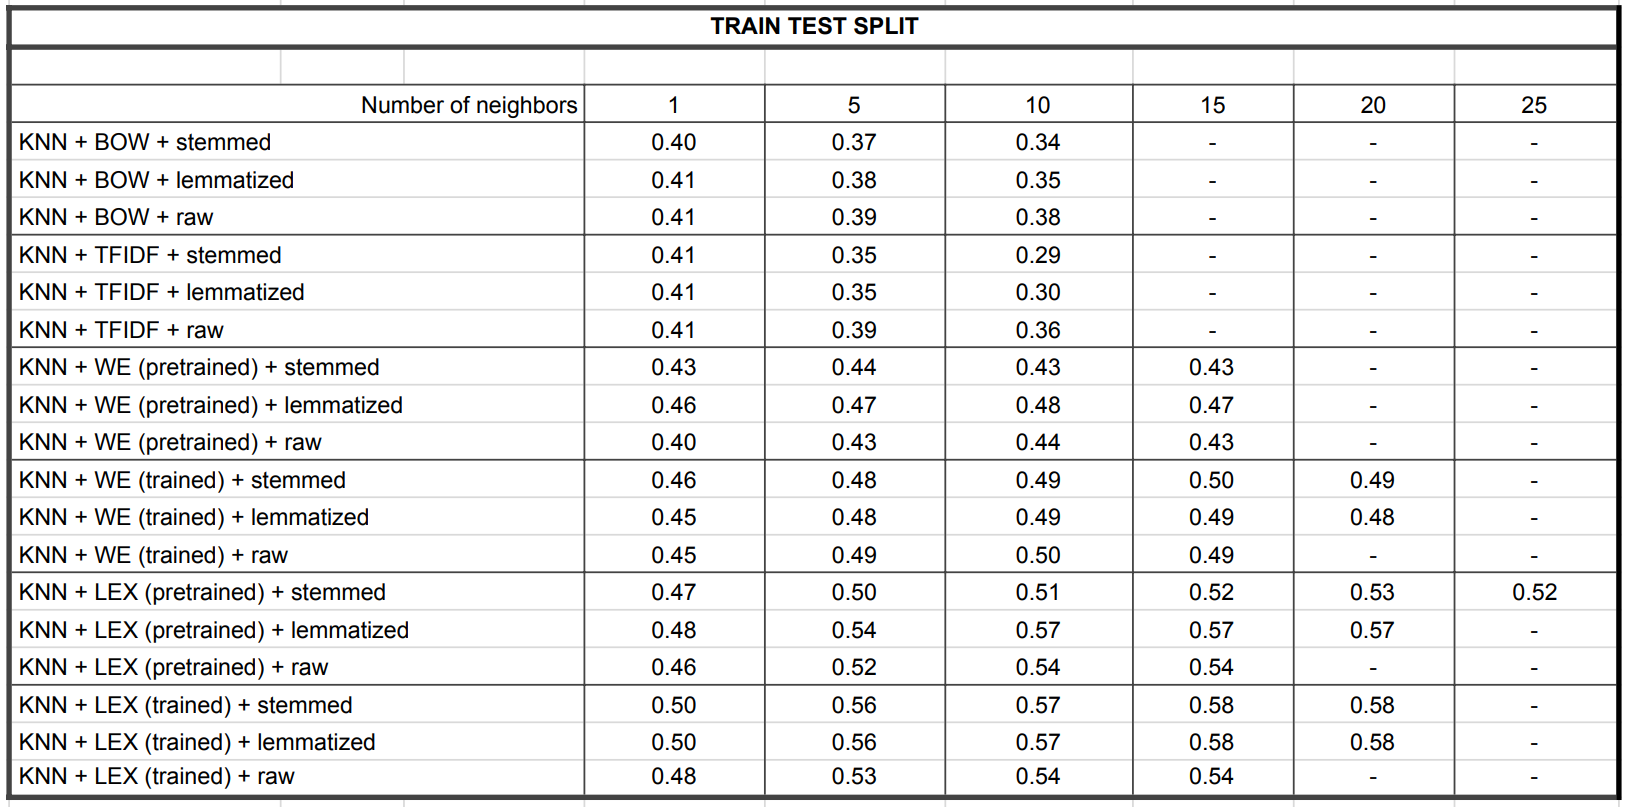

In [7]:
# set the path of the photo testtrainsplitresults.png inside scr folder
Image(filename='/media/admin1/data/COMMON STORAGE/Sxoli/Data Mining/Project/scr/testtrainsplitresults.png', width=1000) 

Also : Round Robin + LEX (pretrained):  0.48 (1 neighbor) | 0.57 (40 neighbors) | 0.56 (45 neighbors)

**Observations #1**

As we can see bag-of-words and tf-idf have better f1 score with 1 neighbor but word embeddings and lexica features with 15-20 neighbors. Also raw data (without any cleaning) were better in bag-of-words and tfidf compared to stemmed or lemmatized data but in word embeddings and lexica features, lemmatized data were better. Although pretrained model is expected to be better, in test train split examples our own trained model works better.This might be explained by the fact that we predict on the same data that we have trained the model with. We should try both in test dataset to be sure.

Based on the previous observations we decide to use lemmatized data for our predictions and test bag-of-word and tfidf with 1 KNN neighbor and word embeddings and lexica features with 15 KNN neighbors. Here is a table with the results on test dataset.

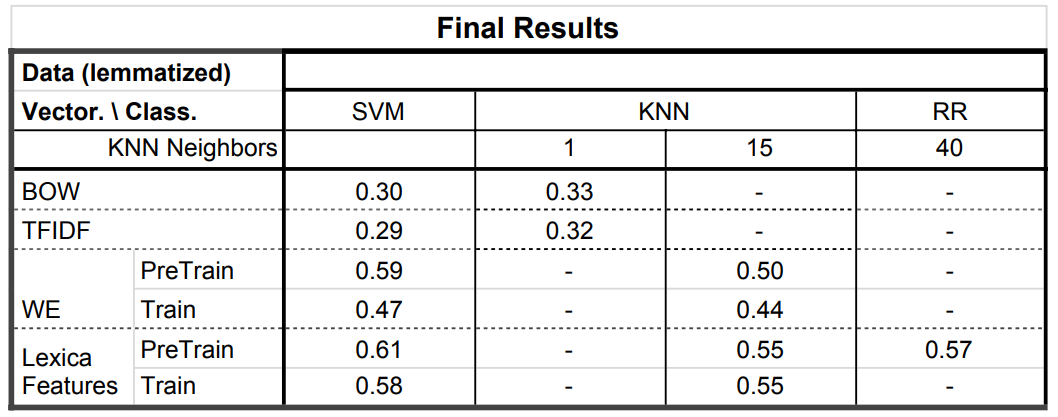

In [10]:
# set the path of the photo results.png inside scr folder
Image(filename='/media/admin1/data/COMMON STORAGE/Sxoli/Data Mining/Project/scr/results.png', width=800) 

**Observations #2**

We notice that bag-of-words is slightly better that tfidf although we would expect the opposite. Word embeddings and lexica features are far better than bow and tfidf. For bow and tfidf SVM is slightly worse than KNN but for word embeddings and lexica features SVM is quite better than KNN. As expected, pretrained word2vec model is better than our own trained model. In fact word embeddings with SVM have the biggest difference between the two models (0.59 - 0.47 = 0.12). The added lexica features increased the f1 score compared to word embeddings and the biggest difference is in SVM with our own trained model (0.58 - 0.47 = 0.11). Round Robin had a quite high f1 score but not higher than lexica features and pretrained word2vec word embeddings. Although we expected Round Robin with lexica features to have the higher f1 score, SVM with lexica features (from pretrained model) had the highest f1 score (0.61). Maybe if we had added more features this score would be even higher ,or maybe if we had normalised the lexica values.

It would be also interesting to test different vector sizes (different number of features) in bag-of-words and tfidf or different combinations of lexicas in lexica feature vectors but because of lack of time and very slow classification functions I didn't.